In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# np.random.seed(23)

In [2]:
allegro_df = pd.read_csv("allegro-api-transactions.csv")

In [3]:
allegro_df_build = allegro_df.sample(frac=0.7, random_state=500)
allegro_df_test = allegro_df.drop(allegro_df_build.index)

## Przekształcanie zmiennych ciągłych na kategoryczne

### Zakodowanie zmiennej celu

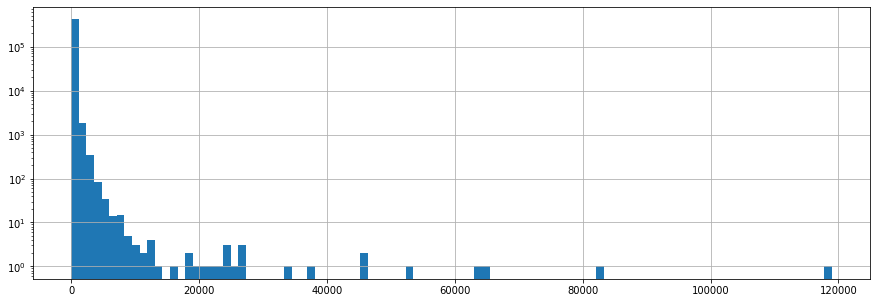

In [4]:
allegro_df["price"].hist(bins = 100, figsize = (15, 5))
plt.yscale('log')
plt.show()

Patrząc na rozkład zmiennej price logicznym wydaję się podział zmiennej na kategorie:
 - "tanio" - jeśli price <= 1500
 - "przeciętna cena" - jeśli 1500 < price <= 3000
 - "drogo" w przeciwnym wypadku

 Taki podział wydaje się być bardziej pasujący niż podział na kwantyle. Budujący zdecydowali się jednak na kwantyle.

In [ ]:
allegro_df_test_fixed['priceEncoded']=pd.qcut(allegro_df_test_fixed['price'], q=3,labels=False)

### Zakodowanie it_seller_rating i it_quantity

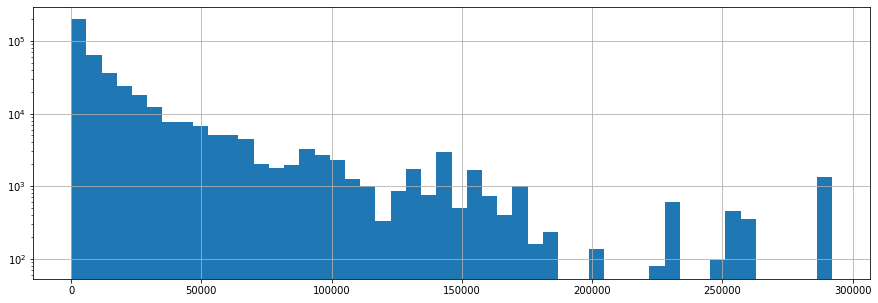

In [19]:
allegro_df["it_seller_rating"].hist(bins = 50, figsize = (15, 5))
plt.yscale('log')
plt.show()

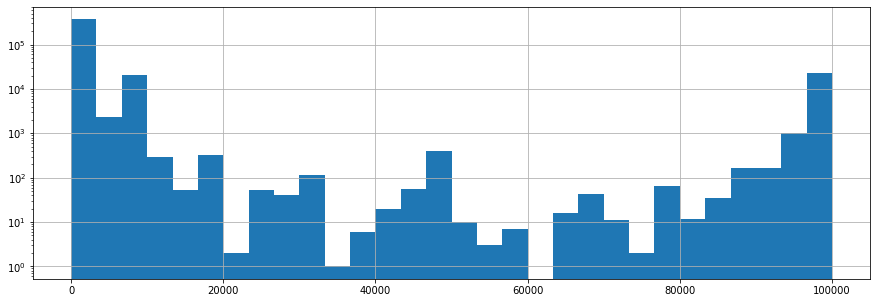

In [20]:
allegro_df["it_quantity"].hist(bins = 30, figsize = (15, 5))
plt.yscale('log')
plt.show()

Budowniczowie ponownie zdecydowali się na podział wartości na kwantyle.

In [ ]:
allegro_df_test_fixed['it_quantityEncoded'] = pd.qcut(allegro_df_test_fixed['it_quantity'], q=5,labels=False)
allegro_df_test_fixed['it_seller_ratingEncoded'] = pd.qcut(allegro_df_test_fixed['it_seller_rating'], q=5,labels=False)

## Zakodowanie zmiennych kategorycznych

### main_category i categories

Ze zmiennej categories wyciągnięto drugą kategorię. Główna i druga kategoria zostały najpierw przetransformowane w mediany z ceny w danej kategorii a następnie zakodowane na podstawie kwantyli. Rozwiązanie wydaje się ciekawe, jednak należy przy tym zapamiętywać mediany, używanych do danych kategorii, czego budowniczy nie zrobili. Mamy teraz więcej pracy, aby je wyciągnąć, żeby móc odpowiednio przekształcić dane do walidacji. Byłoby to uciążliwe przy już wytrenowanym modelu.

In [ ]:
median_encode = allegro_df.groupby('main_category')['price'].median()
median_encode2 = allegro_df.groupby('second_categoryy')['price'].median()
allegro_df_test_fixed.loc[:,'main_categoryMedian'] = allegro_df_test_fixed['main_category'].map(median_encode)
allegro_df_test_fixed['main_categoryEncoded']=pd.qcut(allegro_df_test_fixed['main_categoryMedian'], q=5,labels=False)
allegro_df_test_fixed.loc[:,'second_categoryMedian'] = allegro_df_test_fixed['second_categoryy'].map(median_encode2)
allegro_df_test_fixed['second_categoryEncoded']=pd.qcut(allegro_df_test_fixed['second_categoryMedian'], q=5,labels=False)

### seller

Budowniczowie postanowili pozbyć, się tej kolumny. W daleszej części walidcaji sprawdzimy, że był to błąd

### It_location

Tutaj budowniczowie postanowili zgrupować lokalizacje po miastach. Połączyli większe miasta w Polsce w grupy i wrzucili  mniej popularne lokalizacje do grupy 'Others'

In [ ]:
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "WARSZAWA", "it_location"] = "Warszawa"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "warszawa", "it_location"] = "Warszawa"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Warszawa/ Sprzedaż tylko wysyłkowa", "it_location"] = "Warszawa"

allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "KRAKÓW", "it_location"] = "Kraków"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "kraków", "it_location"] = "Kraków"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Kraków al. Słowackiego 40/1", "it_location"] = "Kraków"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Krakow", "it_location"] = "Kraków"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "krakow", "it_location"] = "Kraków"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "KRAKOW", "it_location"] = "Kraków"

allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "ŁÓDŹ", "it_location"] = "Łódź"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "łódź", "it_location"] = "Łódź"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "lodz", "it_location"] = "Łódź"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Lodz", "it_location"] = "Łódź"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "LODZ", "it_location"] = "Łódź"

allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "POZNAŃ", "it_location"] = "Poznań"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "poznan", "it_location"] = "Poznań"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Poznan", "it_location"] = "Poznań"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "poznań", "it_location"] = "Poznań"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Poznań, ul. Obornicka 337", "it_location"] = "Poznań"

allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "WROCŁAW", "it_location"] = "Wrocław"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "wrocław", "it_location"] = "Wrocław"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "wroclaw", "it_location"] = "Wrocław"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "Wroclaw", "it_location"] = "Wrocław"
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_location"] == "WROCLAW", "it_location"] = "Wrocław"

allegro_df_test_fixed.loc[~allegro_df_test_fixed.it_location.isin(["Warszawa", "Wrocław", "Łódź", "Kraków", "Poznań"]), "it_location"] = "Other"

In [ ]:
allegro_df_test_fixed["it_location"].value_counts()

# KOMENTARZ!

Następnie zostało przeprowadzone kodowanie label_encoderem

In [ ]:
! pip install category_encoders 
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

allegro_df_build_fixed['it_location'] = LabelEncoder().fit_transform(allegro_df_build_fixed.it_location)
allegro_df_build_fixed

## Model na otrzymanych danych

Import bibliotek

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 

Funkcja wypisująca wyniki

In [26]:
def display_scores(scores):
    print("Wyniki:", scores)
    print("Średnia:", scores.mean())
    print("Odchylenie standardowe:", scores.std())

Podział ramki

In [41]:
df_build_all = pd.read_csv("pd2.csv", index_col = 0) # wyeksportowana ramka po preprocessingu budowniczych
df_build = df_build_all.loc[:,['pay_option_on_delivery','pay_option_transfer','it_is_allegro_standard','it_is_brand_zone','main_categoryEncoded','second_categoryEncoded', 'it_quantityEncoded',
       'it_seller_ratingEncoded','it_location', 'priceEncoded']]
X_build = df_build.drop("priceEncoded", axis = 1)
y_build = df_build.priceEncoded

### Dummy

In [28]:
dc = DummyClassifier(strategy='uniform', random_state=32)
dc.fit(X_build, y_build)
dummy_scores_build = cross_val_score(dc, X_build, y_build, scoring='accuracy', cv = 10)
#dummy_scores_test = cross_val_score(dc, X_test, y_test, scoring='accuracy', cv = 10)

In [29]:
display_scores(dummy_scores_build)

Wyniki: [0.33358098 0.33275549 0.33267294 0.33201255 0.3296599  0.3303752
 0.33285178 0.33186115 0.33305816 0.3361126 ]
Średnia: 0.3324940740419544
Odchylenie standardowe: 0.0016726094721823065


In [31]:
#display_scores(dummy_scores_test)

### Drzewa decyzyjne

In [32]:
tree_clas = DecisionTreeClassifier()
tree_clas.fit(X_build, y_build)
tree_scores_build = cross_val_score(tree_clas, X_build, y_build, scoring='accuracy', cv = 10)
#tree_scores_test = cross_val_score(tree_clas, X_test, y_test, scoring='accuracy', cv = 10)

In [33]:
display_scores(tree_scores_build)

Wyniki: [0.54750702 0.54998349 0.54907545 0.55506026 0.54742447 0.55079044
 0.54847897 0.54649771 0.55070789 0.54868535]
Średnia: 0.5494211043435623
Odchylenie standardowe: 0.0023106755309405752


In [ ]:
#display_scores(tree_scores_test)

### SVC

In [ ]:
# długo się liczy
#svc_clas = SVC()
#svc_clas.fit(X_build, y_build)
#svc_scores_build = cross_val_score(svc_clas, X_build, y_build, scoring='accuracy', cv = 10)
#svc_scores_test = cross_val_score(svc_clas, X_test, y_test, scoring='accuracy', cv = 10)

In [ ]:
#display_scores(svc_scores_build)

In [ ]:
#display_scores(svc_scores_test)

### Ustalanie wartości predykcyjnej kolumn

Sprawdzimy predykcyjność tych kolumn, które zostały "niestandardowo" zakodowane.

#### it_location

In [35]:
X_build_temp = X_build.drop(["it_location"], axis = 1)
#X_test_temp = X_test.drop(["it_location"], axis = 1)

tree_clas = DecisionTreeClassifier()
tree_clas.fit(X_build_temp, y_build)
tree_scores_build_temp = cross_val_score(tree_clas, X_build_temp, y_build, scoring='accuracy', cv = 10)
#tree_scores_test_temp = cross_val_score(tree_clas, X_test_temp, y_test, scoring='accuracy', cv = 10)

In [36]:
display_scores(tree_scores_build_temp)

Wyniki: [0.47044742 0.47238732 0.47395575 0.47779429 0.47606076 0.4741817
 0.47773146 0.47649317 0.47455318 0.47863953]
Średnia: 0.47522445764835064
Odchylenie standardowe: 0.0024673443121159106


In [ ]:
#display_scores(tree_scores_test_temp)

Bez kolumny "it_location" model gorzej przewiduje zmienną celu. Zatem została ona poprawnie zakodowana. Oczywiście w miarę możliwości.

#### categories

In [38]:
X_build_temp = X_build.drop(["second_categoryEncoded"], axis = 1)
#X_test_temp = X_test.drop(["second_categoryEncoded"], axis = 1)

tree_clas = DecisionTreeClassifier()
tree_clas.fit(X_build_temp, y_build)
tree_scores_build_temp = cross_val_score(tree_clas, X_build_temp, y_build, scoring='accuracy', cv = 10)
#tree_scores_test_temp = cross_val_score(tree_clas, X_test_temp, y_test, scoring='accuracy', cv = 10)

In [39]:
display_scores(tree_scores_build_temp)

Wyniki: [0.48237576 0.48320125 0.48827803 0.4928595  0.48980518 0.48714244
 0.48767904 0.48697734 0.48417055 0.49098114]
Średnia: 0.48734702390007334
Odchylenie standardowe: 0.0032059795111924897


In [ ]:
#display_scores(tree_scores_test_temp)

Bez kolumny "second_categoryEncoded" model gorzej przewiduje zmienną celu. Zatem została ona poprawnie zakodowana.

#### seller

In [45]:
X_build_temp = X_build.copy()
X_build_temp["seller"] = df_build_all["seller"]

ordinal_encoder = OrdinalEncoder()
X_build_temp["seller"] = ordinal_encoder.fit_transform(X_build_temp[["seller"]])

tree_clas = DecisionTreeClassifier()
tree_clas.fit(X_build_temp, y_build)
tree_scores_build_temp = cross_val_score(tree_clas, X_build_temp, y_build, scoring='accuracy', cv = 10)
#tree_scores_test_temp = cross_val_score(tree_clas, X_test_temp, y_test, scoring='accuracy', cv = 10)

In [46]:
display_scores(tree_scores_build_temp)

Wyniki: [0.63818722 0.6401684  0.64070497 0.63893016 0.63810467 0.63676889
 0.63420977 0.63041235 0.63066001 0.63660379]
Średnia: 0.6364750233399645
Odchylenie standardowe: 0.0034489609893888647


In [ ]:
#display_scores(tree_scores_test_temp)

Jak widać przez usunięcie sprzedawców z ramki, dane budowniczych tracą dużo wartościwych informacji. Model działa lepiej, gdy zostawimy te kolumnę, nawet zakodowaną tak trywialnie jak Ordinary Encoderem